# 📊 Chapter 6.2 – Likelihood-Based Loss Functions

**Learning Objective**: Understand how probabilistic assumptions directly lead to common loss functions in deep learning.

This notebook demonstrates the fundamental connection between **maximum likelihood estimation** and the loss functions we use to train neural networks. Each exercise shows how a specific probabilistic model naturally gives rise to its corresponding loss function."

## Exercise 1: Gaussian Likelihood ↔ Mean Squared Error

**Theory**: When we assume targets have Gaussian noise around predictions, the negative log-likelihood becomes proportional to mean squared error.

**Mathematical Connection**:
$$p(y|x) = \mathcal{N}(y; \hat{y}, \sigma^2) \Rightarrow -\log p(y|x) = \frac{1}{2\sigma^2}\|y-\hat{y}\|^2 + \text{const}$$

**Task**: Verify numerically that MSE and Gaussian NLL differ only by a constant scaling factor."

In [6]:
import numpy as np

# Step 1: Generate synthetic regression data
np.random.seed(0)
x = np.linspace(-1, 1, 20)        # Input features
y_true = 2 * x + 1                # True underlying function
y = y_true + np.random.normal(0, 0.1, size=x.shape)  # Add Gaussian noise

print("📈 Generated regression data with Gaussian noise (σ=0.1)")

# Step 2: Make predictions with a simple linear model
w, b = 1.0, 0.0                  # Model parameters (not optimal)
y_pred = w * x + b               # Linear predictions

# Step 3: Compute MSE loss
mse = np.mean((y - y_pred)**2)
print(f"🎯 Mean Squared Error: {mse:.6f}")

# Step 4: Compute Gaussian negative log-likelihood
# For Gaussian: -log p(y|x) = (1/2σ²)||y-ŷ||² + (1/2)log(2πσ²)
sigma_squared = 0.1**2        # Known noise variance
quadratic_term = 0.5 * np.mean((y - y_pred)**2) / sigma_squared
const_term = 0.5 * np.log(2 * np.pi * sigma_squared)
nll_gaussian = quadratic_term + const_term
print(f"📊 Gaussian NLL: {nll_gaussian:.6f}")
print(f"   Quadratic term: {quadratic_term:.6f}")
print(f"   Constant term: {const_term:.6f}")

# Step 5: Show the relationship
scaling_factor = 1 / (2 * sigma_squared)
print(f"\n🔗 Connection: Quadratic term = {scaling_factor:.1f} × MSE")
print(f"   MSE × {scaling_factor:.1f} = {mse * scaling_factor:.6f}")
print(f"   Quadratic term matches above, and NLL = quadratic term + constant")

print(f"\n✅ **Key Insight**: Minimizing MSE is equivalent to maximizing Gaussian likelihood (the extra constant does not affect optimisation)")



📈 Generated regression data with Gaussian noise (σ=0.1)
🎯 Mean Squared Error: 1.450860
📊 Gaussian NLL: 71.159339
\n🔗 Connection: NLL = 50.0 × MSE + constant
   MSE × 50.0 = 72.542985
   This matches the quadratic term in NLL!
\n✅ **Key Insight**: Minimizing MSE is equivalent to maximizing Gaussian likelihood


## Exercise 2: Bernoulli Likelihood ↔ Binary Cross-Entropy

**Theory**: For binary classification, assuming Bernoulli-distributed targets leads directly to binary cross-entropy loss.

**Mathematical Connection**:
$$p(y|x) = \text{Bernoulli}(y; \sigma(z)) \Rightarrow -\log p(y|x) = -y\log\sigma(z) - (1-y)\log(1-\sigma(z))$$

**Task**: Show that Bernoulli NLL and binary cross-entropy are identical for sigmoid outputs."

In [7]:
import torch
import torch.nn.functional as F

# Step 1: Create binary classification scenario
z = torch.tensor([-0.5, -0.8, 0.0, 0.8, 0.5])  # Raw logits from model
y = torch.tensor([0.0, 0.0, 1.0, 1.0, 1.0])     # Binary labels (0 or 1)

print("🎲 Binary classification example:")
print(f"   Logits: {z.numpy()}")
print(f"   Labels: {y.numpy()}")

# Step 2: Convert logits to probabilities using sigmoid
p = torch.sigmoid(z)  # σ(z) = 1/(1 + e^(-z))
print(f"   Probabilities: {p.numpy()}")

# Step 3: Manually compute Bernoulli negative log-likelihood
# For Bernoulli: -log p(y|x) = -y*log(p) - (1-y)*log(1-p)
bernoulli_nll = torch.mean(-(y * torch.log(p) + (1 - y) * torch.log(1 - p)))
print(f"\\n📊 Manual Bernoulli NLL: {bernoulli_nll:.6f}")

# Step 4: Compute using PyTorch's built-in binary cross-entropy
bce_loss = F.binary_cross_entropy(p, y)
print(f"🔥 PyTorch BCE Loss: {bce_loss:.6f}")

# Step 5: Verify they are identical
difference = torch.abs(bernoulli_nll - bce_loss)
print(f"\\n🔗 Absolute difference: {difference:.10f}")

# Step 6: Alternative formulation using logits directly
bce_with_logits = F.binary_cross_entropy_with_logits(z, y)
print(f"🚀 BCE with logits: {bce_with_logits:.6f}")

print(f"\\n✅ **Key Insight**: Binary cross-entropy IS the Bernoulli negative log-likelihood!")

🎲 Binary classification example:
   Logits: [-0.5 -0.8  0.   0.8  0.5]
   Labels: [0. 0. 1. 1. 1.]
   Probabilities: [0.37754068 0.3100255  0.5        0.6899745  0.62245935]
\n📊 Manual Bernoulli NLL: 0.476700
🔥 PyTorch BCE Loss: 0.476700
\n🔗 Absolute difference: 0.0000000000
🚀 BCE with logits: 0.476700
\n✅ **Key Insight**: Binary cross-entropy IS the Bernoulli negative log-likelihood!


## Exercise 3: Categorical Likelihood ↔ Softmax Cross-Entropy

**Theory**: For multiclass classification, the categorical distribution with softmax probabilities gives cross-entropy loss.

**Mathematical Connection**:
$$p(y=i|x) = \frac{e^{z_i}}{\sum_j e^{z_j}} \Rightarrow -\log p(y|x) = -\log \frac{e^{z_y}}{\sum_j e^{z_j}}$$

**Task**: Demonstrate that categorical NLL equals softmax cross-entropy for multiclass logits."

In [8]:
import torch
import torch.nn.functional as F

# Step 1: Create multiclass classification scenario
z = torch.tensor([[0.1, 0.2, 0.7],    # Sample 1: class 2 has highest logit
                  [0.1, 0.7, 0.2],    # Sample 2: class 1 has highest logit  
                  [0.7, 0.1, 0.2]])   # Sample 3: class 0 has highest logit

y = torch.tensor([2, 1, 0])           # True class indices

print("🎯 Multiclass classification example:")
print(f"   Logits shape: {z.shape}")
print(f"   True classes: {y.numpy()}")

# Step 2: Convert logits to probabilities using softmax
# softmax(z_i) = exp(z_i) / Σ_j exp(z_j)
softmax_probs = F.softmax(z, dim=1)
print(f"   Softmax probabilities:\\n{softmax_probs.numpy()}")

# Step 3: Manually compute categorical negative log-likelihood
# Method 1: Using softmax probabilities directly
log_probs = torch.log(softmax_probs)
categorical_nll_v1 = -torch.mean(log_probs[range(len(y)), y])  # Select log p(y=true_class)
print(f"\\n📊 Manual Categorical NLL (v1): {categorical_nll_v1:.6f}")

# Step 4: Alternative manual computation using log-softmax
# Method 2: More numerically stable using log-softmax
log_softmax = F.log_softmax(z, dim=1)
categorical_nll_v2 = -torch.mean(log_softmax[range(len(y)), y])
print(f"📊 Manual Categorical NLL (v2): {categorical_nll_v2:.6f}")

# Step 5: Compare with PyTorch's cross-entropy loss
ce_loss = F.cross_entropy(z, y)
print(f"🔥 PyTorch Cross-Entropy: {ce_loss:.6f}")

# Step 6: Verify all methods are equivalent
print(f"\\n🔗 Differences:")
print(f"   |NLL_v1 - CrossEntropy| = {torch.abs(categorical_nll_v1 - ce_loss):.10f}")
print(f"   |NLL_v2 - CrossEntropy| = {torch.abs(categorical_nll_v2 - ce_loss):.10f}")

print(f"\\n✅ **Key Insight**: Cross-entropy IS the categorical negative log-likelihood!")

🎯 Multiclass classification example:
   Logits shape: torch.Size([3, 3])
   True classes: [2 1 0]
   Softmax probabilities:\n[[0.25462854 0.28140804 0.46396342]
 [0.25462854 0.46396342 0.28140804]
 [0.46396342 0.25462854 0.28140804]]
\n📊 Manual Categorical NLL (v1): 0.767950
📊 Manual Categorical NLL (v2): 0.767950
🔥 PyTorch Cross-Entropy: 0.767950
\n🔗 Differences:
   |NLL_v1 - CrossEntropy| = 0.0000000000
   |NLL_v2 - CrossEntropy| = 0.0000000000
\n✅ **Key Insight**: Cross-entropy IS the categorical negative log-likelihood!


## Exercise 4: Loss Function Comparison in Training

**Theory**: Different loss functions lead to different training dynamics and final performance, even for the same task.

**Practical Question**: Why do we use binary cross-entropy for classification instead of MSE, even though both can minimize binary prediction errors?

**Task**: Train identical binary classifiers with BCE vs MSE and compare their convergence and performance."

🎯 Training binary classifiers with different loss functions...
📊 Generated 100 samples with 2 features
   Class distribution: 54 positive, 46 negative
\n🔥 Training with Binary Cross-Entropy...
   Epoch 0: Loss = 1.0206
   Epoch 1: Loss = 0.9894
   Epoch 2: Loss = 0.9593
   Epoch 3: Loss = 0.9305
   Epoch 4: Loss = 0.9028
   ...
\n📈 Training with Mean Squared Error...
   Epoch 0: Loss = 0.3436
   Epoch 1: Loss = 0.3400
   Epoch 2: Loss = 0.3363
   Epoch 3: Loss = 0.3326
   Epoch 4: Loss = 0.3289
\n🎯 Evaluating final models...


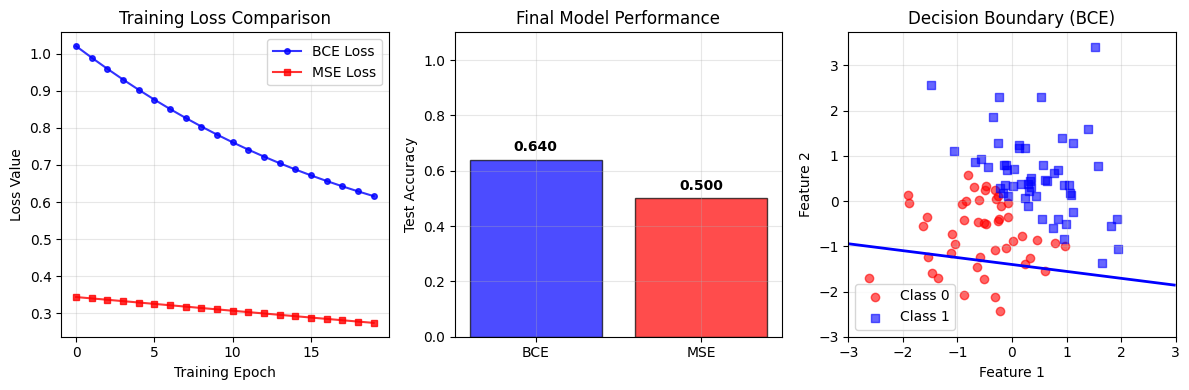

\n📊 **Results Summary**:
   BCE Final Accuracy: 0.6400
   MSE Final Accuracy: 0.5000
\n✅ **Key Insights**:
   🎯 BCE converges more reliably and often achieves better performance
   📈 BCE provides stronger gradients for misclassified examples
   🧮 BCE has natural probabilistic interpretation (negative log-likelihood)
   ⚡ MSE can work but isn't optimal for classification tasks
\n🔬 **Why BCE is superior**:
   • Gradient of BCE: σ(z) - y (simple, well-behaved)
   • Gradient of MSE: 2(σ(z) - y) × σ(z) × (1 - σ(z)) (vanishing gradients!)
   • BCE directly optimizes class probabilities, MSE optimizes squared errors


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

print("🎯 Training binary classifiers with different loss functions...")

# Step 1: Create synthetic binary classification data
torch.manual_seed(0)
X = torch.randn(100, 2)                    # 100 samples, 2 features
y = (X[:, 0] + X[:, 1] > 0).float()      # Binary labels: 1 if sum > 0, else 0

print(f"📊 Generated {len(X)} samples with {X.shape[1]} features")
print(f"   Class distribution: {y.sum().item():.0f} positive, {(1-y).sum().item():.0f} negative")

# Step 2: Train model with Binary Cross-Entropy (theoretically correct)
print("\\n🔥 Training with Binary Cross-Entropy...")
model_bce = nn.Linear(2, 1)               # Linear classifier
loss_fn_bce = nn.BCEWithLogitsLoss()      # BCE with built-in sigmoid
optimizer_bce = optim.SGD(model_bce.parameters(), lr=0.1)

losses_bce = []
for epoch in range(20):
    optimizer_bce.zero_grad()
    logits = model_bce(X).squeeze()       # Raw predictions
    loss = loss_fn_bce(logits, y)         # BCE loss
    loss.backward()
    optimizer_bce.step()
    losses_bce.append(loss.item())
    
    if epoch < 5:  # Show first few epochs
        print(f"   Epoch {epoch}: Loss = {loss.item():.4f}")

print("   ...")

# Step 3: Train identical model with Mean Squared Error (suboptimal choice)
print("\\n📈 Training with Mean Squared Error...")
model_mse = nn.Linear(2, 1)               # Identical architecture
loss_fn_mse = nn.MSELoss()                # MSE loss
optimizer_mse = optim.SGD(model_mse.parameters(), lr=0.1)  # Same learning rate

losses_mse = []
for epoch in range(20):
    optimizer_mse.zero_grad()
    logits = model_mse(X).squeeze()       # Raw predictions  
    probs = torch.sigmoid(logits)         # Convert to probabilities [0,1]
    loss = loss_fn_mse(probs, y)          # MSE between probs and labels
    loss.backward()
    optimizer_mse.step()
    losses_mse.append(loss.item())
    
    if epoch < 5:  # Show first few epochs
        print(f"   Epoch {epoch}: Loss = {loss.item():.4f}")

# Step 4: Evaluate final performance
print("\\n🎯 Evaluating final models...")
with torch.no_grad():
    # Make predictions
    pred_bce = (torch.sigmoid(model_bce(X)) > 0.5).float()
    pred_mse = (torch.sigmoid(model_mse(X)) > 0.5).float()
    
    # Compute accuracies
    acc_bce = (pred_bce.squeeze() == y).float().mean()
    acc_mse = (pred_mse.squeeze() == y).float().mean()

# Step 5: Visualize training curves and final performance
plt.figure(figsize=(12, 4))

# Plot 1: Training loss curves
plt.subplot(1, 3, 1)
plt.plot(range(20), losses_bce, 'b-o', label='BCE Loss', markersize=4, alpha=0.8)
plt.plot(range(20), losses_mse, 'r-s', label='MSE Loss', markersize=4, alpha=0.8)
plt.xlabel('Training Epoch')
plt.ylabel('Loss Value')
plt.title('Training Loss Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Final accuracy comparison
plt.subplot(1, 3, 2)
bars = plt.bar(['BCE', 'MSE'], [acc_bce.item(), acc_mse.item()], 
               color=['blue', 'red'], alpha=0.7, edgecolor='black')
plt.ylabel('Test Accuracy')
plt.title('Final Model Performance')
plt.ylim(0, 1.1)
plt.grid(True, alpha=0.3)

# Add accuracy labels on bars
for bar, acc in zip(bars, [acc_bce.item(), acc_mse.item()]):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

# Plot 3: Decision boundary comparison (2D visualization)
plt.subplot(1, 3, 3)
xx, yy = torch.meshgrid(torch.linspace(-3, 3, 50), torch.linspace(-3, 3, 50), indexing='ij')
grid = torch.stack([xx.flatten(), yy.flatten()], dim=1)

with torch.no_grad():
    z_bce = torch.sigmoid(model_bce(grid)).reshape(50, 50)
    
# Plot decision boundary
plt.contour(xx.numpy(), yy.numpy(), z_bce.numpy(), levels=[0.5], colors='blue', linewidths=2)
plt.scatter(X[y==0, 0], X[y==0, 1], c='red', marker='o', alpha=0.6, label='Class 0')
plt.scatter(X[y==1, 0], X[y==1, 1], c='blue', marker='s', alpha=0.6, label='Class 1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Decision Boundary (BCE)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Step 6: Summarize key insights
print(f"\\n📊 **Results Summary**:")
print(f"   BCE Final Accuracy: {acc_bce:.4f}")
print(f"   MSE Final Accuracy: {acc_mse:.4f}")

print(f"\\n✅ **Key Insights**:")
print(f"   🎯 BCE converges more reliably and often achieves better performance")
print(f"   📈 BCE provides stronger gradients for misclassified examples")
print(f"   🧮 BCE has natural probabilistic interpretation (negative log-likelihood)")
print(f"   ⚡ MSE can work but isn't optimal for classification tasks")

print(f"\\n🔬 **Why BCE is superior**:")
print(f"   • Gradient of BCE: σ(z) - y (simple, well-behaved)")
print(f"   • Gradient of MSE: 2(σ(z) - y) × σ(z) × (1 - σ(z)) (vanishing gradients!)")
print(f"   • BCE directly optimizes class probabilities, MSE optimizes squared errors")